In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn import model_selection
cudnn.benchmark = True
plt.ion()   # interactive mode
#torch.multiprocessing.set_start_method('spawn')

d:\Anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'sklearn'

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
# import os
# #import pandas as pd
# from torchvision.io import read_image
# from torch.utils.data import Dataset
# import pathlib
# import string

# class CustomImageDataset(Dataset):
#     def __init__(self, data_dir, transform=None, target_transform=None):
#         data_dir = pathlib.Path(data_dir)
#         self.img_labels = list(data_dir.glob('*/*.*'))
#         self.img_dir = data_dir
#         self.transform = transform
#         self.target_transform = target_transform

#     def __len__(self):
#         return len(self.img_labels)

#     def __getitem__(self, idx):
#         img_path = self.img_labels[idx]
#         image = read_image(img_path)
#         parts = img_path.split(os.path.sep)
#         label = parts[-2]
#         if self.transform:
#             image = self.transform(image)
#         if self.target_transform:
#             label = self.target_transform(label)
#         return image, label

# #data_dir = 'D:/Uni/Senior-2/GP2/Datasets/bumps_detection_01/NEWEST_DATASET_BUMPS'
# #data_dir = pathlib.Path(data_dir)
# dataset = CustomImageDataset()


In [4]:
from collections import Counter
import sklearn
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'D:/Uni/Senior-2/GP2/Datasets/bumps_detection_01/NEWEST_DATASET_BUMPS'
#full_dataset = datasets.ImageFolder('D:/Uni/Senior-2/GP2/Datasets/bumps_detection_01/NEWEST_DATASET_BUMPS')


#train_set, val_set = torch.utils.data.random_split(full_dataset, [train_count, val_count])
#image_datasets = {'train': train_set, 'val': val_set}
image_datasets = {x: datasets.ImageFolder(data_dir,
                                    transform=data_transforms[x])
                  for x in ['train', 'val']}

targets = image_datasets['train'].targets
class_names = image_datasets['train'].classes

full_len = len(image_datasets['train'])
val_prec = 0.25
val_count = int(full_len * val_prec)
train_count = full_len-val_count

indices = list(range(full_len))
train_indices, val_indices = model_selection.train_test_split(indices, test_size=val_prec)
data_indices = {'train': train_indices, 'val': val_indices}

image_datasets = {x: torch.utils.data.Subset(image_datasets[x],
                                          data_indices[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4,)
              for x in ['train', 'val']}
# for x in ['train', 'val']:
#     dataloaders[x].data.to(device)
#     dataloaders[x].target.to(device)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(class_names)
print(dict(Counter(targets)))

class_weights=sklearn.utils.class_weight.compute_class_weight('balanced',classes=np.unique(targets),y=targets)
class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)

print(class_weights) #([1.0000, 1.0000, 4.0000, 1.0000, 0.5714])


['001', '002']
{0: 4747, 1: 3267}
tensor([0.8441, 1.2265], device='cuda:0')


In [5]:
import torchvision.models as models
model = models.squeezenet1_1(pretrained=True)
model.eval()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [6]:
#transfer learning
# freeze all weights except last layer

#freeze all weights
for param in model.parameters():
    param.requires_grad = False

#create new last layer replacement
num_ftrs = model.classifier[1].in_channels
model.classifier[1]  = nn.Conv2d(num_ftrs, 2, kernel_size=(1, 1), stride=(1, 1))


In [7]:
#convert to cuda
model = model.to(device)

In [8]:
import torchmetrics
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    try:
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                if phase == 'val':
                    scheduler.step(epoch_acc)
                
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

            print()

    except KeyboardInterrupt:
        print ('KeyboardInterrupt exception is caught during training, returning best results:')
    finally:
        #print ('KeyboardInterrupt exception is caught')
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(best_model_wts)
        return model, best_acc
    

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                #ax = plt.subplot(num_images//2, 2, images_so_far)
                #ax.axis('off')
                #ax.set_title(f'predicted: {class_names[preds[j]]}')
                fig = plt.figure(figsize = (10,10))
                imshow(inputs.cpu().data[j], f'predicted: {class_names[preds[j]]}')

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:

optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, mode='max')
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [11]:
model, best_val_acc = train_model(model, criterion, optimizer,
                         exp_lr_scheduler, num_epochs=40)

Epoch 0/39
----------


c:\Users\mohab\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


train Loss: 0.3802 Acc: 0.8225
val Loss: 0.3069 Acc: 0.8323

Epoch 1/39
----------
train Loss: 0.3286 Acc: 0.8398
val Loss: 0.2668 Acc: 0.8683

Epoch 2/39
----------
train Loss: 0.3147 Acc: 0.8494
val Loss: 0.2723 Acc: 0.8538

Epoch 3/39
----------
train Loss: 0.3039 Acc: 0.8532
val Loss: 0.2575 Acc: 0.8917

Epoch 4/39
----------
train Loss: 0.3005 Acc: 0.8584
val Loss: 0.2536 Acc: 0.8917

Epoch 5/39
----------
train Loss: 0.3016 Acc: 0.8562
val Loss: 0.2497 Acc: 0.8932

Epoch 6/39
----------
train Loss: 0.3001 Acc: 0.8581
val Loss: 0.2890 Acc: 0.8792

Epoch 7/39
----------
train Loss: 0.2829 Acc: 0.8671
val Loss: 0.2497 Acc: 0.8922

Epoch 8/39
----------
train Loss: 0.2885 Acc: 0.8612
val Loss: 0.2502 Acc: 0.8872

Epoch 9/39
----------
train Loss: 0.2777 Acc: 0.8679
val Loss: 0.2430 Acc: 0.8972

Epoch 10/39
----------
train Loss: 0.2850 Acc: 0.8629
val Loss: 0.2429 Acc: 0.8987

Epoch 11/39
----------
train Loss: 0.2778 Acc: 0.8684
val Loss: 0.2427 Acc: 0.8997

Epoch 12/39
----------
t

In [29]:
torch.save(model.state_dict(), './SqueezeNetV1_1x224x' + '{:.2f}'.format(best_val_acc*100).replace('.', '_'))

In [17]:
#model = TheModelClass(*args, **kwargs)
#model = models.squeezenet1_1(pretrained=True)
model.load_state_dict(torch.load('./SqueezeNetV1_1x224x91_32'))
model.eval()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

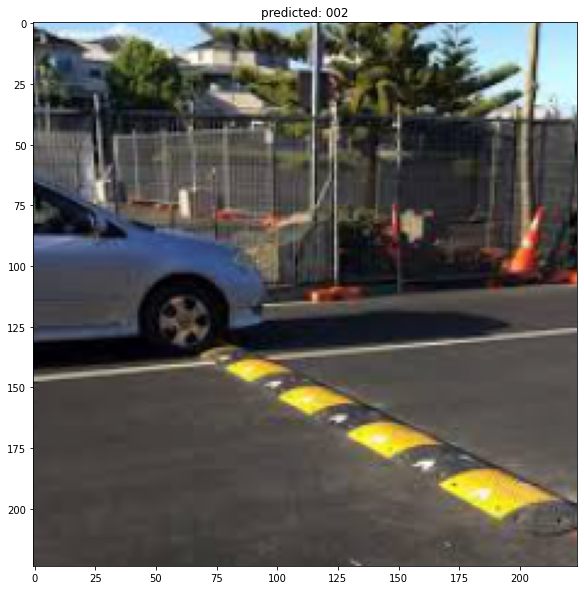

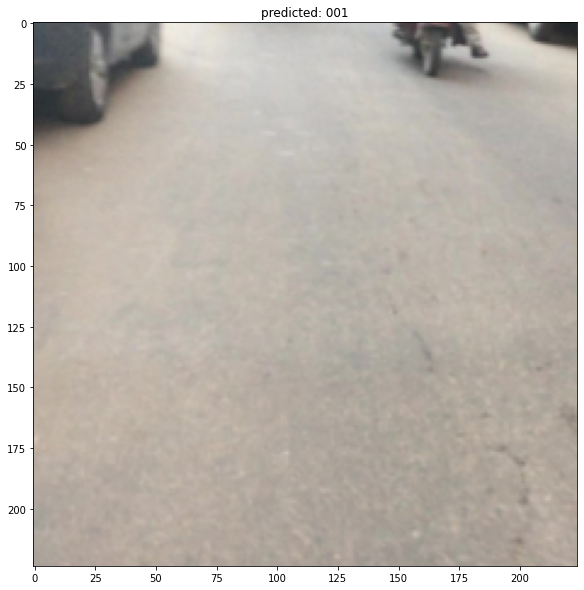

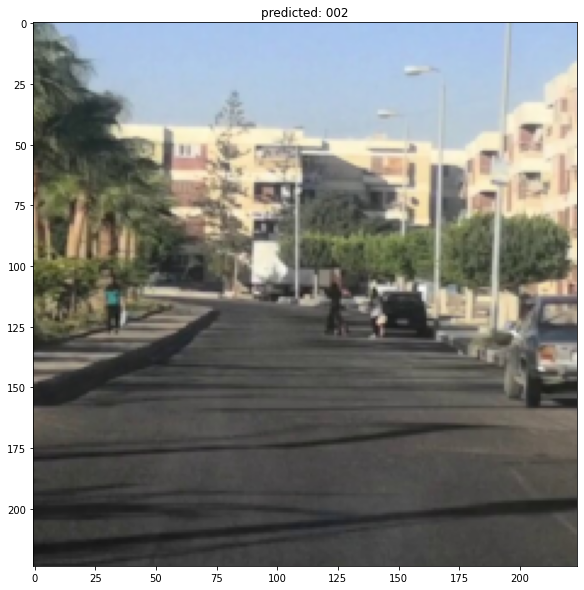

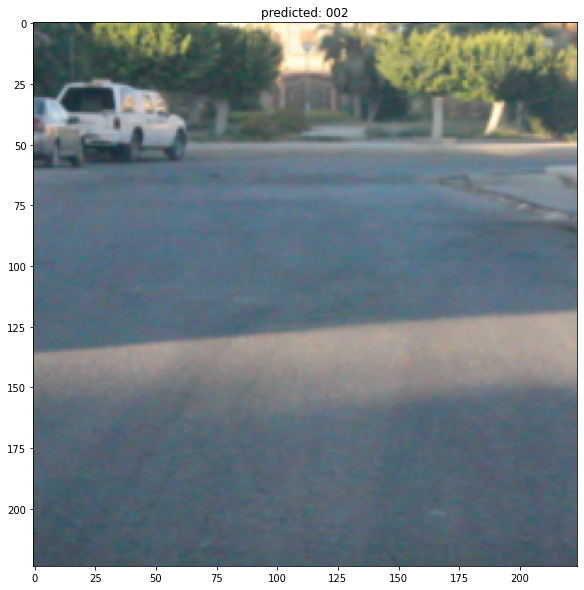

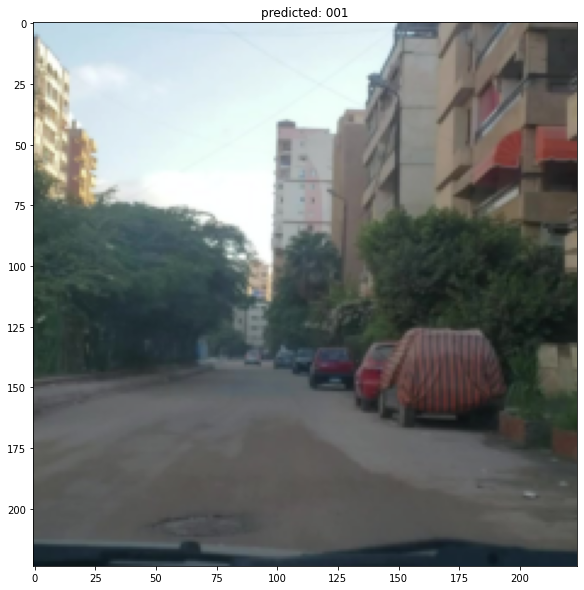

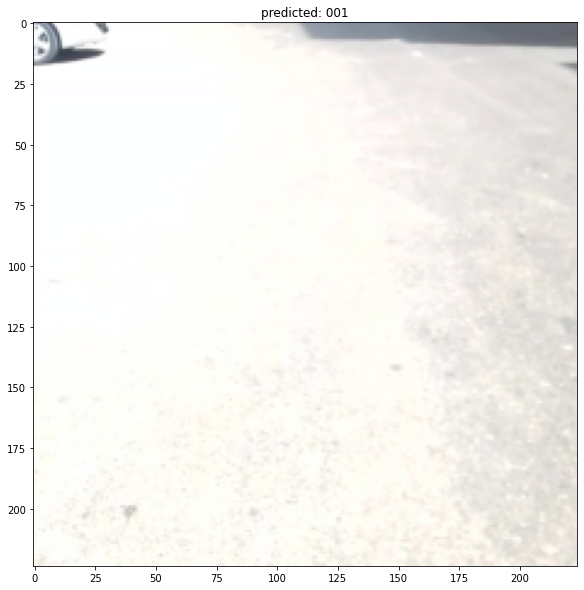

In [19]:
visualize_model(model_conv)

plt.ioff()
plt.show()